<a href="https://colab.research.google.com/github/aviralsomani/driv-face-classifier/blob/master/AviralSomani_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e50e420e70cbe0c1a1868197ddf446bc3fbf1f6824e039e4ac0cd53ad4a58b7d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import random
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

tmp_dir = 'data/tmp'
img_dir = 'data/img'
trn_dir = 'data/trn'
val_dir = 'data/val'
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

Using TensorFlow backend.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def load_data():
  if not os.path.exists(img_dir):
    os.makedirs(tmp_dir)
    os.makedirs(img_dir)
    print("Downloading dataset to "+ tmp_dir)
    file = wget.download(uci_url, out=tmp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(tmp_dir)
    pzf = PyZipFile(tmp_dir + '/DrivFace/DrivImages.zip')
    pzf.extractall(tmp_dir)
    print("Moving files to " + img_dir)
    for file in os.listdir(tmp_dir + '/DrivImages'):
      shutil.move(tmp_dir+'/DrivImages/'+file, img_dir+'/'+file)
    shutil.move(tmp_dir + '/DrivFace/drivPoints.txt', img_dir + '/drivPoints.txt')
    shutil.rmtree(tmp_dir)

In [0]:
def move_train_val(train_dir, validation_dir, files, ratio):
  ind = 0
  for fname in files:
    src = os.path.join(img_dir, fname + '.jpg')
    t_dest = os.path.join(train_dir, fname + '')
    ind = ind + 1
    if ind < len(files)*ratio:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(train_dir, fname + '.jpg'))
    else:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(validation_dir, fname + '.jpg'))

In [0]:
import matplotlib.pyplot as plt
def show_plots(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.ylim(0, 1)
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [0]:
def split_data(img_dir, trn_dir, val_dir, ratio):
  if not os.path.exists(trn_dir):
    os.makedirs(trn_dir)
    os.makedirs(val_dir)
    tff_dir = os.path.join(trn_dir, 'ff')
    tll_dir = os.path.join(trn_dir, 'll')
    tlr_dir = os.path.join(trn_dir, 'lr')
    os.makedirs(tff_dir)
    os.makedirs(tll_dir)
    os.makedirs(tlr_dir)
    vff_dir = os.path.join(val_dir, 'ff')
    vll_dir = os.path.join(val_dir, 'll')
    vlr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(vff_dir)
    os.makedirs(vll_dir)
    os.makedirs(vlr_dir)
    df = pd.read_csv(img_dir + '/drivPoints.txt')['fileName']
    ff = [f for f in df if 'f' in f]
    random.shuffle(ff)
    ll = [f for f in df if 'll' in f]
    random.shuffle(ll)
    lr = [f for f in df if 'lr' in f]
    random.shuffle(lr)
    ind = 0
    move_train_val(tff_dir, vff_dir, ff, ratio)
    move_train_val(tll_dir, vll_dir, ll, ratio)
    move_train_val(tlr_dir, vlr_dir, lr, ratio)

In [0]:
def return_data(img_dir, trn_dir, val_dir):
  for out in [trn_dir, val_dir]:
    for lab in ['ff', 'll', 'lr']:
      src = os.path.join(out, lab)
      files = os.listdir(src)
      for f in files:
        shutil.move(os.path.join(src, f), img_dir)
    shutil.rmtree(out)

In [0]:
def split_k_bins(trn_dir, k):
  bins = range(0, k)
  for b in bins:
    path = os.path.join(trn_dir, ('b'+str(b)))
    if not os.path.exists(path):
      os.makedirs(path)
      os.makedirs(os.path.join(path, 'ff'))
      os.makedirs(os.path.join(path, 'll'))
      os.makedirs(os.path.join(path, 'lr'))
  for lab in ['ff', 'll', 'lr']:
    src = os.path.join(trn_dir, lab)
    for f in os.listdir(src):
      bin_dir = os.path.join(trn_dir, ('b' + str(random.choice(bins))))
      shutil.move(os.path.join(src, f), os.path.join(bin_dir, lab))
    shutil.rmtree(src)

In [0]:
def coalesce_train_val(trn_dir, j):
  target = 'b' + str(j)
  bins = [b for b in os.listdir(trn_dir) if b != target]
  ingroup = os.path.join(trn_dir, 'in')
  os.makedirs(ingroup)
  os.makedirs(os.path.join(ingroup, 'ff'))
  os.makedirs(os.path.join(ingroup, 'll'))
  os.makedirs(os.path.join(ingroup, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      srclab = os.path.join(src, lab)
      for f in os.listdir(srclab):
        shutil.copy(os.path.join(srclab, f), os.path.join(ingroup, lab))
  outgroup = os.path.join(trn_dir, 'out')
  os.makedirs(outgroup)
  os.makedirs(os.path.join(outgroup, 'ff'))
  os.makedirs(os.path.join(outgroup, 'll'))
  os.makedirs(os.path.join(outgroup, 'lr'))
  outbin = os.path.join(trn_dir, target)
  for lab in ['ff', 'll', 'lr']:
    srclab = os.path.join(outbin, lab)
    for f in os.listdir(srclab):
      shutil.copy(os.path.join(srclab, f), os.path.join(outgroup, lab))


In [0]:
def decoalesce_train_val(trn_dir):
  ingroup = os.path.join(trn_dir, 'in')
  outgroup = os.path.join(trn_dir, 'out')
  shutil.rmtree(ingroup)
  shutil.rmtree(outgroup)

In [0]:
def return_bins(trn_dir):
  bins = os.listdir(trn_dir)
  os.makedirs(os.path.join(trn_dir, 'ff'))
  os.makedirs(os.path.join(trn_dir, 'll'))
  os.makedirs(os.path.join(trn_dir, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      insrc = os.path.join(src, lab)
      for f in os.listdir(insrc):
        shutil.move(os.path.join(insrc, f), os.path.join(trn_dir, lab))
    shutil.rmtree(src)

In [0]:
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
def run_k_fold_cross_val(model, k):
  tr_dgen = ImageDataGenerator(rescale=1./255)
  vl_dgen = ImageDataGenerator(rescale=1./255)
  split_k_bins(trn_dir, k)
  for i in range(0, k):
    print('Bin ', i, 'out of', k)
    coalesce_train_val(trn_dir, i)
    tr_gen = tr_dgen.flow_from_directory(os.path.join(trn_dir, 'in'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

    vl_gen = vl_dgen.flow_from_directory(os.path.join(trn_dir, 'out'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')
    hist = model.fit_generator(tr_gen, steps_per_epoch=100, epochs=10,
                               validation_data=vl_gen, validation_steps=50)
    show_plots(hist)
    decoalesce_train_val(trn_dir)
  return_bins(trn_dir)


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        padding='same', 
                        input_shape=(64, 64, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Found 325 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 16s 164ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 5.5062e-05 - val_acc: 0.9939
Epoch 2/10
100/100 [==============================] - 16s 164ms/step - loss: 2.1121e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.9929
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0332 - acc: 0.9958 - val_loss: 0.0000e+00 - val_acc: 0.9808
Epoch 4/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0188 - acc: 0.9979 - val_loss: 0.0000e+00 - val_acc: 0.9878
Epoch 5/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0118 - acc: 0.9990 - val_loss: 2.6762e-06 - val_acc: 0.9818
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 6.9303e-05 - acc: 1.0000 - val_loss: 0.3383 - val_acc: 0.9798
Epoch 7/10
100/100 [==============================] - 16s 160ms/step - loss: 2.9

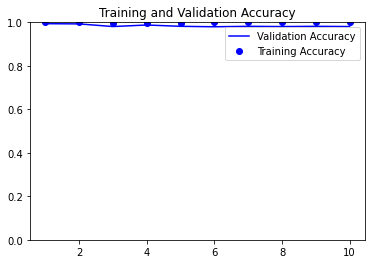

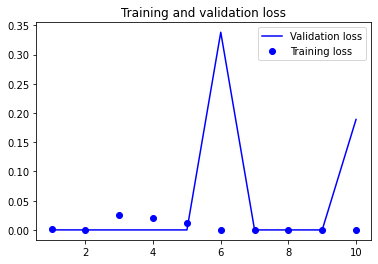

Found 326 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0132 - acc: 0.9974 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 161ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 161ms/step - loss: 3.9225e-05 - acc: 1.0000 - val_loss: 5.6624e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 163ms/step - loss: 1.2022e-06 - acc: 1.0000 - val_loss: 1.6830e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 0.0350 - acc: 0.9933 - val_loss: 0.2318 - val_acc: 0.9725
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0417 - acc: 0.9932 - val_loss: 0.1592 - val_acc: 0.9939
Epoch 7/10
100/100 [==============================] - 16s 160ms/step - loss: 0.0860 

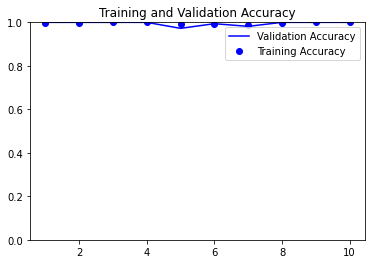

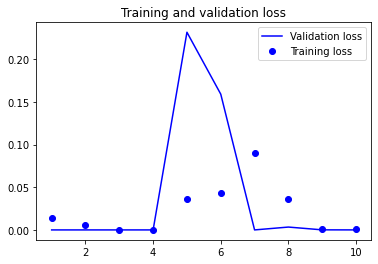

Found 315 images belonging to 3 classes.
Found 168 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 172ms/step - loss: 0.0210 - acc: 0.9969 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 160ms/step - loss: 2.5951e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 1.3271e-05 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 164ms/step - loss: 8.5265e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 157ms/step - loss: 1.3816e-05 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 158ms/step - loss: 1.6137e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 156ms/

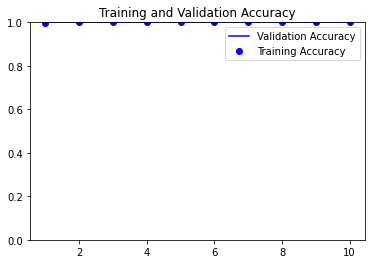

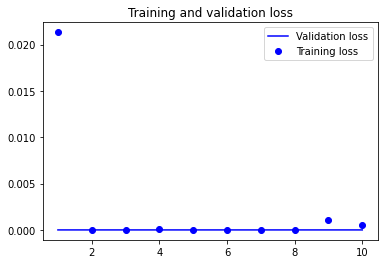

In [47]:
run_k_fold_cross_val(model, k=3)

In [50]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')
model.evaluate_generator(test_gen)

Found 123 images belonging to 3 classes.


[0.0, 0.9512194991111755]

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Found 472 images belonging to 3 classes.
Found 11 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 170ms/step - loss: 1.2734e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 155ms/step - loss: 1.2566e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 156ms/step - loss: 1.3431e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 158ms/step - loss: 1.7353e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 161ms/step - loss: 3.7632e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 162ms/step - loss: 4.6439e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 155

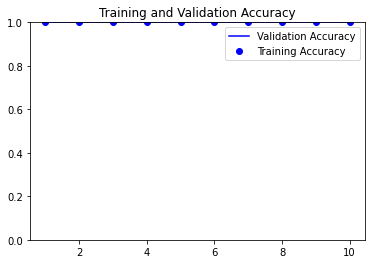

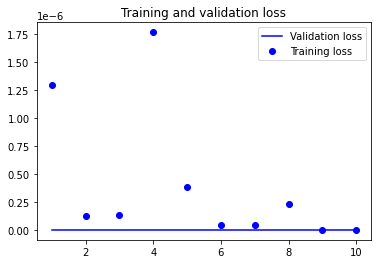

Found 463 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 172ms/step - loss: 7.8705e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 161ms/step - loss: 0.1038 - acc: 0.9896 - val_loss: 7.5698e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 162ms/step - loss: 0.0192 - acc: 0.9949 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 161ms/step - loss: 7.5675e-04 - acc: 0.9995 - val_loss: 2.7477e-06 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 159ms/step - loss: 4.6678e-05 - acc: 1.0000 - val_loss: 3.0193e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 170ms/step - loss: 6.9158e-05 - acc: 1.0000 - val_loss: 9.9679e-05 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 158ms/step 

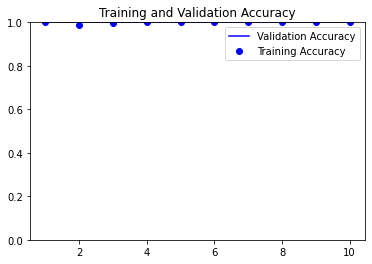

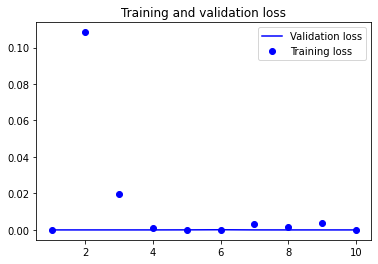

Found 463 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 169ms/step - loss: 2.3004e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 162ms/step - loss: 3.0745e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 7.2469e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 161ms/step - loss: 2.6727e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 161ms/step - loss: 3.6707e-04 - acc: 1.0000 - val_loss: 1.4901e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 2.1403e-05 - acc: 1.0000 - val_loss: 5.9605e-09 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 164

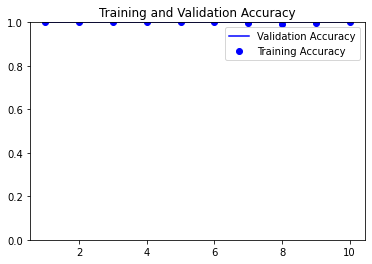

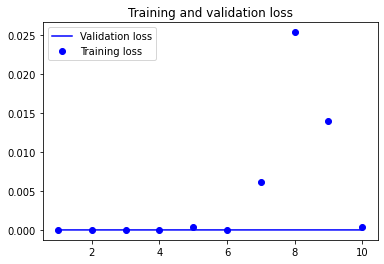

Found 464 images belonging to 3 classes.
Found 19 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 171ms/step - loss: 5.4592e-05 - acc: 1.0000 - val_loss: 2.8860e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 161ms/step - loss: 2.6726e-05 - acc: 1.0000 - val_loss: 2.0830e-06 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 3.6906e-05 - acc: 1.0000 - val_loss: 5.3704e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 162ms/step - loss: 2.6679e-04 - acc: 1.0000 - val_loss: 1.7568e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 163ms/step - loss: 1.4734e-06 - acc: 1.0000 - val_loss: 1.4431e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 3.8010e-07 - acc: 1.0000 - val_loss: 1.4431e-07 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 162

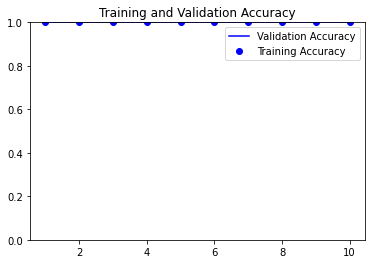

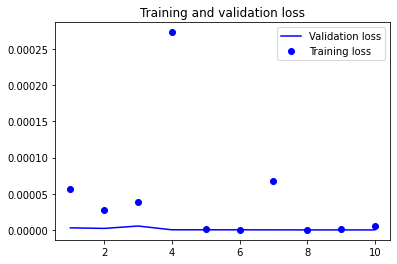

Found 472 images belonging to 3 classes.
Found 11 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 16s 163ms/step - loss: 8.4131e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 15s 154ms/step - loss: 4.4938e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 155ms/step - loss: 4.4030e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 156ms/step - loss: 2.3482e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 158ms/step - loss: 5.1446e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 161ms/step - loss: 1.3958e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 15s 153

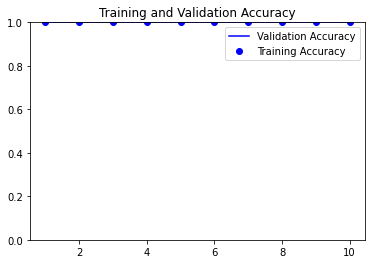

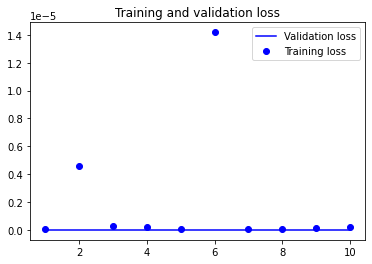

Found 471 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 166ms/step - loss: 4.8647e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 156ms/step - loss: 1.3043e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 156ms/step - loss: 8.5925e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 157ms/step - loss: 1.1565e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 8.4156e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 162ms/step - loss: 2.1282e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 155

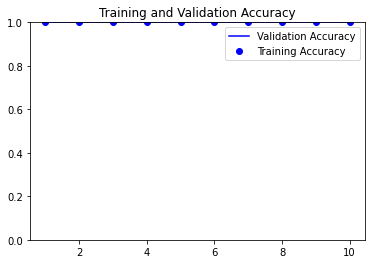

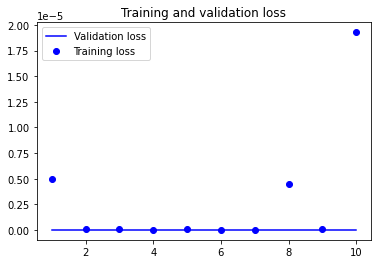

Found 467 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 173ms/step - loss: 3.2894e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 161ms/step - loss: 2.9519e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 161ms/step - loss: 1.3934e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 161ms/step - loss: 4.4220e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 162ms/step - loss: 1.5558e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 1.2087e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 164

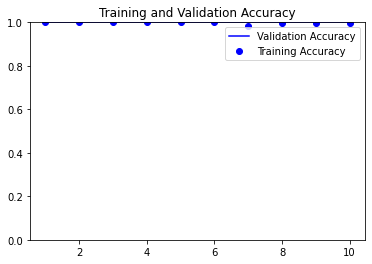

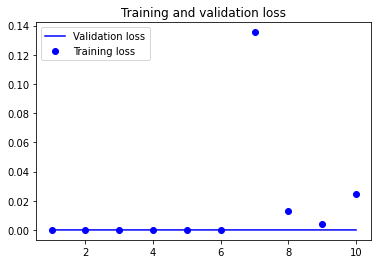

Found 470 images belonging to 3 classes.
Found 13 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 170ms/step - loss: 1.5223e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 158ms/step - loss: 1.0551e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 1.1027e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 159ms/step - loss: 7.9966e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 160ms/step - loss: 2.4973e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 2.1374e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 159

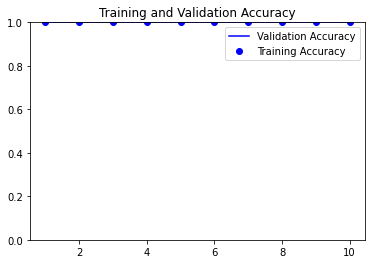

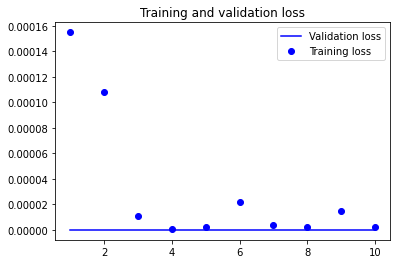

Found 460 images belonging to 3 classes.
Found 23 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 167ms/step - loss: 1.0233e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 159ms/step - loss: 1.6681e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 161ms/step - loss: 9.9682e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 157ms/step - loss: 1.1090e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 158ms/step - loss: 1.2120e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 3.2962e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 15s 154

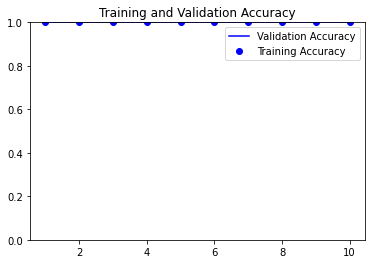

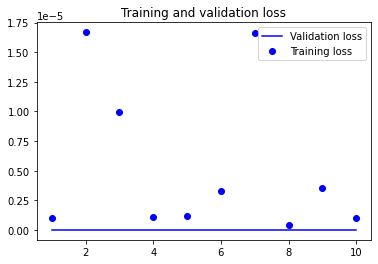

Found 472 images belonging to 3 classes.
Found 11 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 17s 167ms/step - loss: 6.5487e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 16s 155ms/step - loss: 9.4779e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 16s 156ms/step - loss: 2.8338e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 16s 158ms/step - loss: 2.0248e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 16s 159ms/step - loss: 1.0455e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 16s 163ms/step - loss: 2.5988e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 16s 156

In [0]:
run_k_fold_cross_val(model, 30)

In [0]:
model.evaluate_generator(test_gen)

In [0]:
decoalesce_train_val(trn_dir)
return_bins(trn_dir)